In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import adfuller
import lime

import shap
shap.initjs()
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv("../working_data/dataset.csv", index_col=0)

In [3]:
df = df[df["Category"] != "Industrial Crops"]

## Creating working data frame

In [4]:
#df['Year'] = pd.to_datetime(df['Year'], format='%Y')
#df.set_index("Year", inplace=True)
# getting list of names
categories = df["Category"].unique()

## Creating the metrics data frame

In [5]:
shap_df = pd.DataFrame()

## Random Forest Regression

### Setting up dataframe

#### - Solving for stationarity

In [6]:
imputer = KNNImputer(n_neighbors=4)
adf_df = pd.DataFrame(columns=df.columns)

for cate in categories: 
    # Selects category
    crop_df = df[df["Category"] == cate]
    num_cols = crop_df.select_dtypes(include=[np.number])
    # Selects column for ADF Test
    for col in num_cols:
        if crop_df[col].count() < 5:
            continue
        adf_result = adfuller(crop_df[col])
        while adf_result[1] > 0.05:
            crop_df[col] = crop_df[col].diff()
            crop_df[num_cols.columns] = imputer.fit_transform(crop_df[num_cols.columns])
            adf_result = adfuller(crop_df[col])

    adf_df = pd.concat([adf_df, crop_df])

#### - Transforming time series data to supervised learning (adding lags to variables)

In [7]:
main_df = pd.DataFrame(columns=adf_df.columns)
imputer = KNNImputer(n_neighbors=4)

# Sliding Window
for cate in categories: 
    # Selects category
    crop_df = adf_df[adf_df["Category"] == cate]
    num_cols = crop_df.select_dtypes(include=[np.number])
    for col in num_cols.columns:   
        for i in range(1, 3):
            crop_df[f'{col}-{i}'] = crop_df[col].shift(i)

    main_df = pd.concat([main_df, crop_df])
    num_cols = main_df.select_dtypes(include=[np.number])
    main_df[num_cols.columns] = imputer.fit_transform(main_df[num_cols.columns])

## Running the model

,Features Vegetables and Legumes,Coeffcients - Vegetables and Legumes
0,Summer <= 0.00,-14.865875
1,Mean CO2 (ppm) <= 0.00,13.297718
2,Year-Round <= 0.00,12.592137
3,Mean CO2 (ppm)-2 <= 0.00,11.556373
4,Mean CO2 (ppm)-1 <= 0.00,7.524171
5,Yield (tonnes/ha)-2 <= 0.04,3.898972
6,Fall <= 0.00,3.241508
7,Spring <= 0.00,2.821661
8,Devil-1 <= 0.00,-1.727082
9,Devil <= 0.00,-1.678983


,Features Cereals,Coeffcients - Cereals
0,Mean CO2 (ppm)-2 <= 0.00,1.707395
1,Summer <= 0.00,-1.196698
2,0.00 < Fall <= 1.00,0.662322
3,Mean CO2 (ppm) <= 0.00,0.465623
4,Mean CO2 (ppm)-1 <= 0.00,-0.360294
5,Tropical Nights-2 > 0.22,0.192283
6,Hot Days-1 <= 0.50,0.143421
7,Hail-2 <= 0.49,0.131372
8,Ice-2 <= 0.50,0.128600
9,Devil-1 <= 0.50,0.122215


,Features Fruits and Nuts,Coeffcients - Fruits and Nuts
0,Mean CO2 (ppm) > 0.00,7.535208
1,Fall <= 0.00,5.275941
2,Spring <= 0.00,3.313659
3,Mean CO2 (ppm)-1 <= 0.00,1.831358
4,Yield (tonnes/ha)-1 <= 0.17,1.489824
5,Tropical Nights-1 > 0.22,1.437125
6,Hot Days-2 > 0.39,-1.221856
7,Devil-2 <= 0.50,-1.115826
8,Tornado-2 <= 0.50,-1.029128
9,Air Temp Mean > 0.67,0.952853


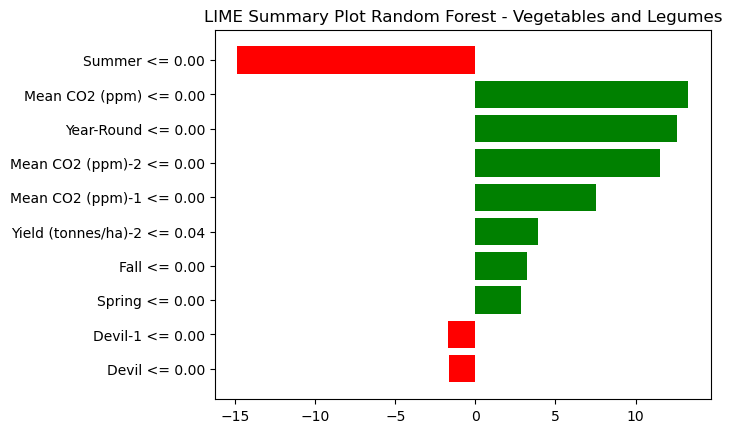

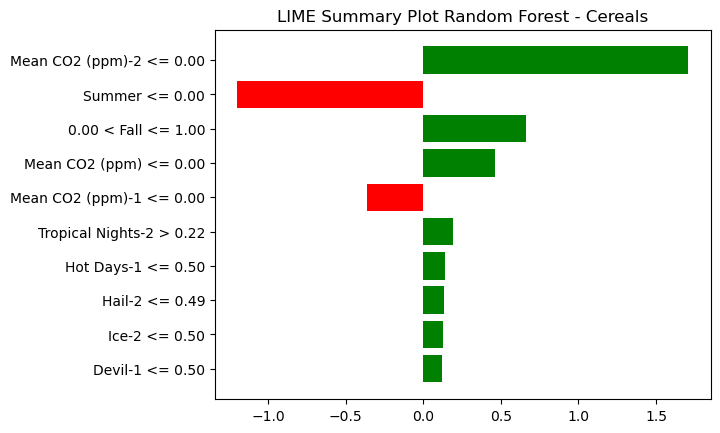

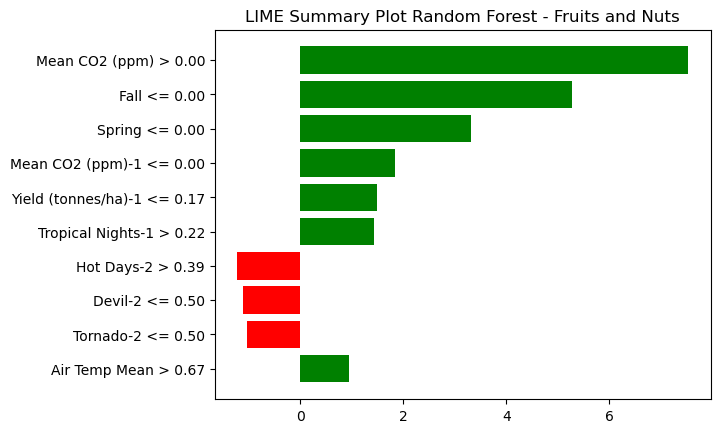

In [9]:
scaler = MinMaxScaler()
for cat in categories:
   crop_df = main_df[main_df['Category'] == cat]
   encoded_df = pd.get_dummies(crop_df[["Season"]], prefix='', prefix_sep='')
   encoded_df = encoded_df.drop(encoded_df.columns[-2], axis=1)

   y = crop_df[['Yield (tonnes/ha)']]
   x = crop_df.drop(['Yield (tonnes/ha)', "Item", "Category", "Season"], axis=1)
   x = pd.concat([x, encoded_df], axis=1)

   mean = x.mean()
   std = x.std()
   lower_bound = mean - 2 * std
   upper_bound = mean + 2 * std
   x = x.clip(lower_bound, upper_bound, axis=1)

   x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
   
   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=42)
   regressor = SVR(kernel="rbf", C=100, epsilon=0.15)
   regressor.fit(x_train, y_train)
   
   #prediction of new value
   y_pred = regressor.predict(x_test)
   
   #lime implementation
   explainer = lime.lime_tabular.LimeTabularExplainer(np.array(x_train),
                  feature_names=x_test.columns, 
                  class_names=['Yield(tonnes/ha)'], mode='regression')
   exp = explainer.explain_instance(x_test.iloc[0], 
   regressor.predict, num_features=10)
   exp_list = [(feat, abs(coeff)) for feat, coeff in exp.as_list()] # add absolute value of coefficients
   exp_list.sort(key=lambda x: x[1], reverse=True)
   exp.as_pyplot_figure()
   plt.title("LIME Summary Plot Random Forest - " + cat)
   display(pd.DataFrame(exp.as_list(),  columns=['Features ' + cat, 'Coeffcients - ' + cat]))
